In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import optuna 
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

# About Dataset

This dataset captures the daily mental wellness patterns of individuals over a 30-day period, including mood ratings, sleep quality, screen time, social interaction, and productivity levels. The aim is to analyze behavioral trends, explore the relationship between variables, and possibly predict mood or productivity using ML.

In [2]:
train = pd.read_csv('../data/mental_wellness_train.csv')
test = pd.read_csv('../data/mental_wellness_test.csv')
tracker = pd.read_csv('../data/mental_wellness_tracker.csv')

## 💡 EDA (Exploratory Data Analysis)

In [3]:
train.head()

,User_ID,Date,Mood_Score,Sleep_Hours,Sleep_Quality,Screen_Time_Hours,Physical_Activity_Min,Social_Interaction_Hours,Work_Productivity_Score,Weather,Diet_Quality,Stress_Level
0,U038,2023-06-07,7,10.0,Excellent,5.1,41,1.8,10,Sunny,Good,3
1,U046,2023-06-19,2,5.7,Good,5.5,36,0.9,3,Sunny,Good,8
2,U015,2023-06-03,3,7.5,Good,1.0,7,6.6,3,Cloudy,Good,8
3,U014,2023-06-24,4,5.6,Good,3.7,35,1.3,4,Rainy,Average,5
4,U016,2023-06-02,10,7.3,Excellent,5.4,29,3.6,10,Sunny,Average,1


In [4]:
test.head()

,User_ID,Date,Mood_Score,Sleep_Hours,Sleep_Quality,Screen_Time_Hours,Physical_Activity_Min,Social_Interaction_Hours,Work_Productivity_Score,Weather,Diet_Quality,Stress_Level
0,U001,2023-06-02,6,8.0,Good,4.8,0,3.4,6,Cloudy,Average,4
1,U001,2023-06-09,4,10.0,Excellent,4.0,39,3.4,7,Sunny,Average,6
2,U001,2023-06-14,8,6.5,Fair,4.4,34,1.4,9,Sunny,Good,1
3,U001,2023-06-15,10,8.0,Fair,4.0,62,0.0,10,Cloudy,Poor,1
4,U001,2023-06-21,6,7.2,Poor,4.5,14,1.7,7,Sunny,Good,4


In [5]:
tracker.head()

,User_ID,Date,Mood_Score,Sleep_Hours,Sleep_Quality,Screen_Time_Hours,Physical_Activity_Min,Social_Interaction_Hours,Work_Productivity_Score,Weather,Diet_Quality,Stress_Level
0,U001,2023-06-01,5,8.5,Fair,10.0,14,1.1,6,Rainy,Poor,5
1,U001,2023-06-02,6,8.0,Good,4.8,0,3.4,6,Cloudy,Average,4
2,U001,2023-06-03,7,7.4,Good,3.5,38,2.3,8,Cloudy,Good,6
3,U001,2023-06-04,3,7.9,Fair,4.5,46,0.9,5,Rainy,Average,7
4,U001,2023-06-05,4,6.9,Good,2.5,7,0.0,4,Cloudy,Good,7


### 1. Basic Information of Dataset

In [6]:
print('Train shape:', train.shape)
print('Test shape:', test.shape)
print('Tracker shape:', tracker.shape)

Train shape: (1200, 12)
Test shape: (300, 12)
Tracker shape: (1500, 12)


In [7]:
print('Train info:')
train.info()

Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   User_ID                   1200 non-null   object 
 1   Date                      1200 non-null   object 
 2   Mood_Score                1200 non-null   int64  
 3   Sleep_Hours               1200 non-null   float64
 4   Sleep_Quality             1200 non-null   object 
 5   Screen_Time_Hours         1200 non-null   float64
 6   Physical_Activity_Min     1200 non-null   int64  
 7   Social_Interaction_Hours  1200 non-null   float64
 8   Work_Productivity_Score   1200 non-null   int64  
 9   Weather                   1200 non-null   object 
 10  Diet_Quality              1200 non-null   object 
 11  Stress_Level              1200 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 112.6+ KB


In [8]:
print('Train describe:')
train.describe().round()

Train describe:


,Mood_Score,Sleep_Hours,Screen_Time_Hours,Physical_Activity_Min,Social_Interaction_Hours,Work_Productivity_Score,Stress_Level
count,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0
mean,6.0,7.0,5.0,30.0,2.0,7.0,4.0
std,2.0,1.0,2.0,15.0,1.0,2.0,2.0
min,1.0,3.0,1.0,0.0,0.0,1.0,1.0
25%,5.0,6.0,4.0,19.0,1.0,5.0,2.0
50%,6.0,7.0,5.0,29.0,2.0,7.0,4.0
75%,7.0,8.0,6.0,39.0,3.0,9.0,6.0
max,10.0,10.0,12.0,80.0,7.0,10.0,10.0


In [9]:
train.describe(include='O')

,User_ID,Date,Sleep_Quality,Weather,Diet_Quality
count,1200,1200,1200,1200,1200
unique,50,30,4,3,3
top,U003,2023-06-04,Good,Sunny,Good
freq,28,45,434,408,749


In [10]:
test.describe().round()

,Mood_Score,Sleep_Hours,Screen_Time_Hours,Physical_Activity_Min,Social_Interaction_Hours,Work_Productivity_Score,Stress_Level
count,300.0,300.0,300.0,300.0,300.0,300.0,300.0
mean,6.0,7.0,5.0,30.0,2.0,7.0,4.0
std,2.0,1.0,2.0,15.0,1.0,2.0,2.0
min,1.0,3.0,1.0,0.0,0.0,1.0,1.0
25%,5.0,6.0,4.0,20.0,1.0,5.0,2.0
50%,6.0,7.0,5.0,30.0,2.0,7.0,4.0
75%,8.0,8.0,6.0,39.0,3.0,9.0,6.0
max,10.0,10.0,11.0,71.0,7.0,10.0,10.0


In [11]:
tracker.describe().round()

,Mood_Score,Sleep_Hours,Screen_Time_Hours,Physical_Activity_Min,Social_Interaction_Hours,Work_Productivity_Score,Stress_Level
count,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
mean,6.0,7.0,5.0,30.0,2.0,7.0,4.0
std,2.0,1.0,2.0,15.0,1.0,2.0,2.0
min,1.0,3.0,1.0,0.0,0.0,1.0,1.0
25%,5.0,6.0,4.0,20.0,1.0,5.0,2.0
50%,6.0,7.0,5.0,29.0,2.0,7.0,4.0
75%,7.0,8.0,6.0,39.0,3.0,9.0,6.0
max,10.0,10.0,12.0,80.0,7.0,10.0,10.0


### 2. Check for Missing Values

In [12]:
print('Missing values:\n')
print(train.isnull().sum())

Missing values:

User_ID                     0
Date                        0
Mood_Score                  0
Sleep_Hours                 0
Sleep_Quality               0
Screen_Time_Hours           0
Physical_Activity_Min       0
Social_Interaction_Hours    0
Work_Productivity_Score     0
Weather                     0
Diet_Quality                0
Stress_Level                0
dtype: int64


### 3. Distribution of Target Variable

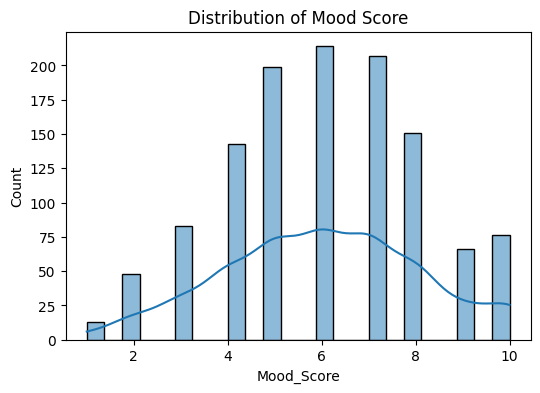

In [13]:
plt.figure(figsize=(6, 4))
sns.histplot(train['Mood_Score'], kde=True)
plt.title('Distribution of Mood Score')
plt.show()

### 4. Correlation with Numerical Variables

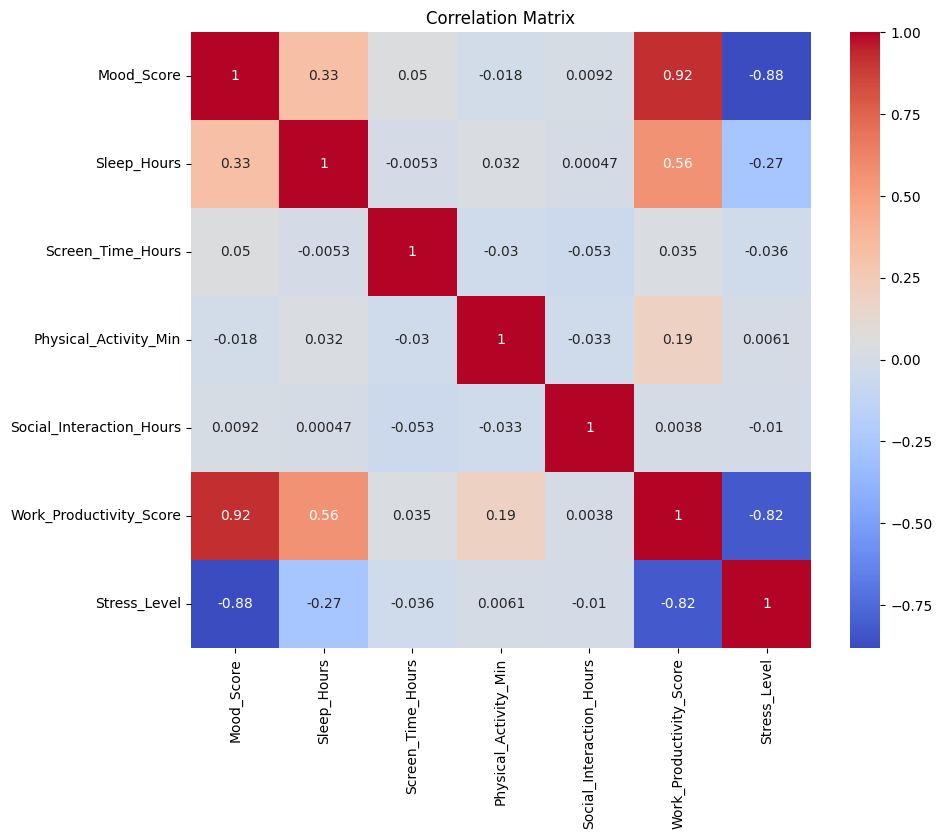

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(train.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### 5. Boxplot Numerical Variables

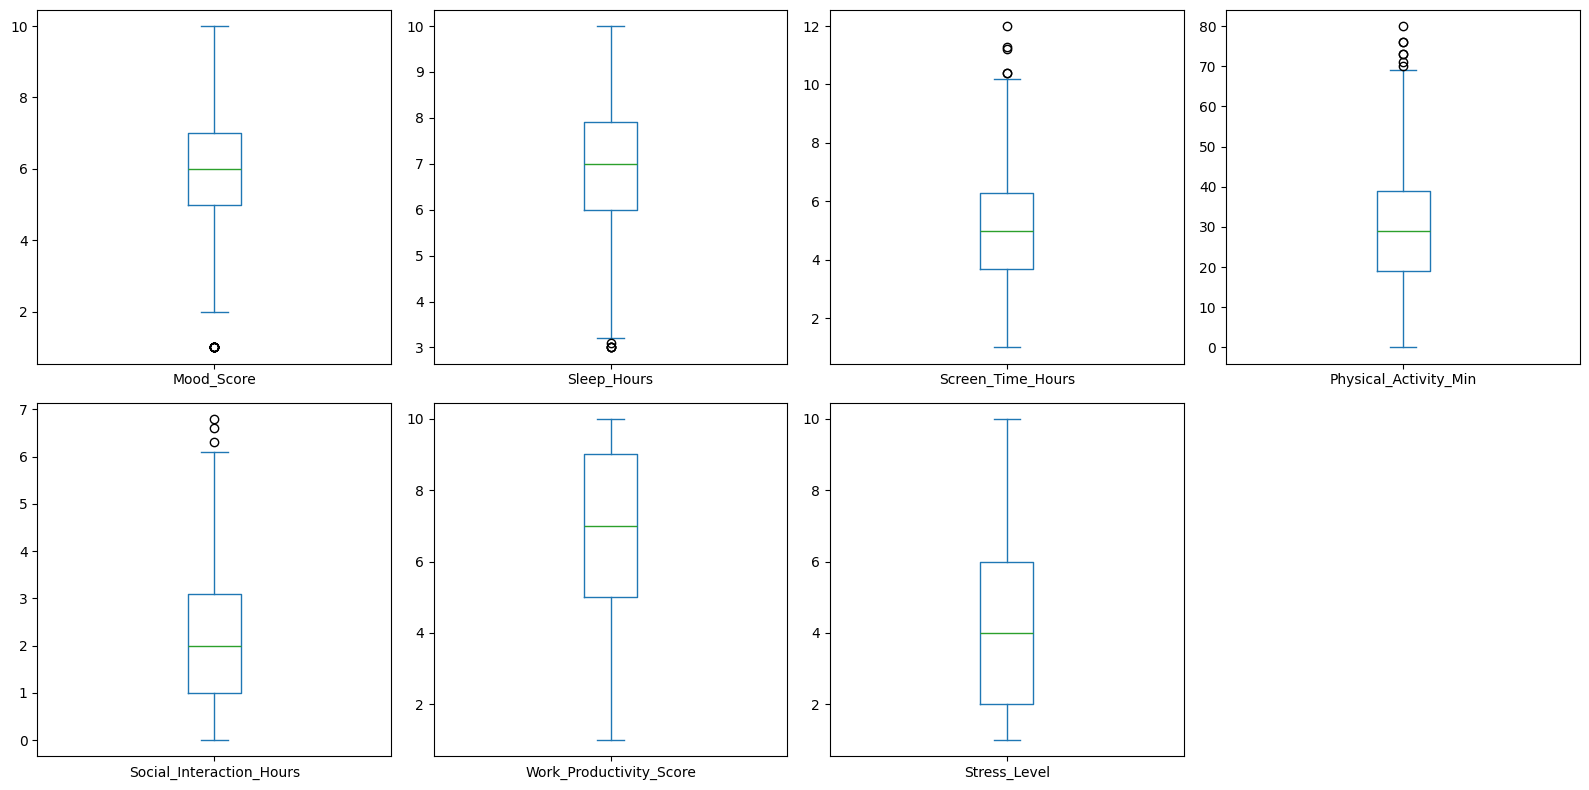

In [15]:
num_cols = train.select_dtypes(include=[np.number]).columns 
train[num_cols].plot(kind='box', subplots=True, layout=(2, 4), figsize=(16, 8), sharex=False)
plt.tight_layout()
plt.show()

### 6. Analytics Categorical Features

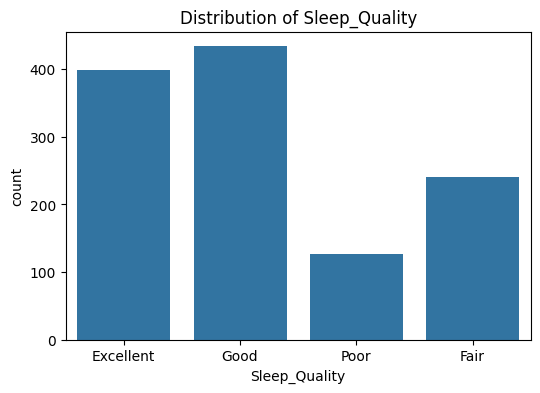

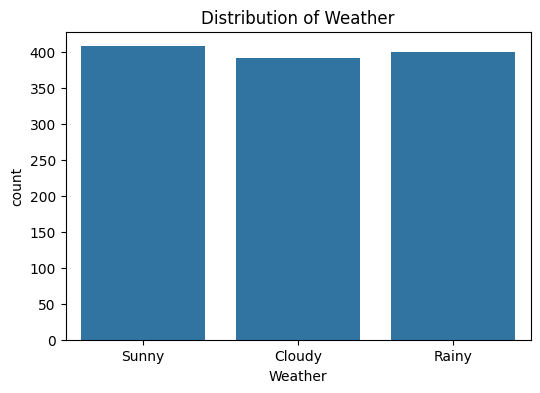

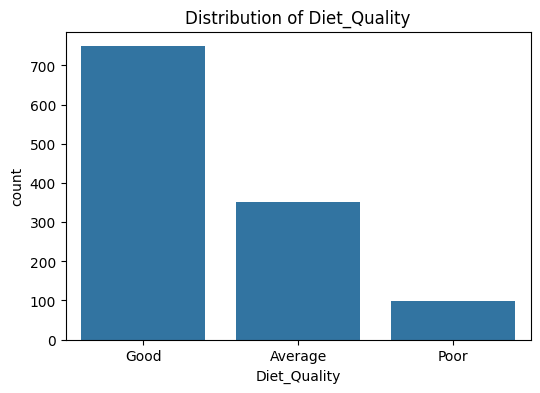

In [16]:
cat_cols = ['Sleep_Quality', 'Weather', 'Diet_Quality']
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=train)
    plt.title(f'Distribution of {col}')
    plt.show()

## Preprocessing

In [17]:
train['is_train'] = 1
test['is_train'] = 0

df_all = pd.concat([train, test], ignore_index=True)

In [18]:
# Encode fiture kategorikal
le_sleep_quality = LabelEncoder()
le_weather = LabelEncoder()
le_diet_quality = LabelEncoder()

df_all['Sleep_Quality'] = le_sleep_quality.fit_transform(df_all['Sleep_Quality'])
df_all['Weather'] = le_weather.fit_transform(df_all['Weather'])
df_all['Diet_Quality'] = le_diet_quality.fit_transform(df_all['Diet_Quality'])

df_all.drop(columns=['Date', 'User_ID'], inplace=True)

In [19]:
df_train = df_all[df_all['is_train'] == 1].drop(columns=['is_train'])
df_test = df_all[df_all['is_train'] == 0].drop(columns=['is_train'])

X_multi = df_train.drop(columns=['Mood_Score', 'Stress_Level'])
y_multi = df_train[['Mood_Score', 'Stress_Level']]

X_train_multi, X_val_multi, y_train_multi, y_val_multi = train_test_split(X_multi, y_multi, test_size=.2, random_state=42)

# scaling
scaler = StandardScaler()
X_train_multi_scaled = scaler.fit_transform(X_train_multi)
X_val_multi_scaled = scaler.transform(X_val_multi)
X_test_multi_scaled = scaler.transform(df_test.drop(columns=['Mood_Score', 'Stress_Level']))


In [20]:
# Model regressor
multi_models = {
    'RandomForest': MultiOutputRegressor(RandomForestRegressor(random_state=42)),
    'GradientBoosting': MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
    'XGBoost': MultiOutputRegressor(XGBRegressor(random_state=42)),
    'XGBRF': MultiOutputRegressor(XGBRFRegressor(random_state=42)),
    'Decision Tree': MultiOutputRegressor(DecisionTreeRegressor(random_state=42))
}

print("=== Multi-Output Regression Results ===")
for name, model in multi_models.items():
    print(f"Model: {name}")
    print('-' * 30)
    
    # Training
    model.fit(X_train_multi_scaled, y_train_multi)
    
    # Prediction
    y_pred_multi = model.predict(X_val_multi_scaled)
    
    # Evaluation
    targets = ['Mood_Score', 'Stress_Level']
    
    for i, target in enumerate(targets):
        y_true = y_val_multi.iloc[:, i]
        y_pred = y_pred_multi[:, i]
        
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        
        print(f' {target}:')
        print(f' MAE: {mae:.4f}')
        print(f' RMSE: {rmse:.4f}')
        print(f' R2 Score: {r2:.4f}')
        
    print('\n' + '='*50 + '\n')

    
    

=== Multi-Output Regression Results ===
Model: RandomForest
------------------------------
 Mood_Score:
 MAE: 0.3197
 RMSE: 0.4883
 R2 Score: 0.9444
 Stress_Level:
 MAE: 0.8920
 RMSE: 1.1345
 R2 Score: 0.7180


Model: GradientBoosting
------------------------------
 Mood_Score:
 MAE: 0.3275
 RMSE: 0.4735
 R2 Score: 0.9477
 Stress_Level:
 MAE: 0.8599
 RMSE: 1.0963
 R2 Score: 0.7366


Model: XGBoost
------------------------------
 Mood_Score:
 MAE: 0.3549
 RMSE: 0.5304
 R2 Score: 0.9345
 Stress_Level:
 MAE: 0.8718
 RMSE: 1.1053
 R2 Score: 0.7323


Model: XGBRF
------------------------------
 Mood_Score:
 MAE: 0.4026
 RMSE: 0.5427
 R2 Score: 0.9314
 Stress_Level:
 MAE: 0.9077
 RMSE: 1.1461
 R2 Score: 0.7122


Model: Decision Tree
------------------------------
 Mood_Score:
 MAE: 0.2792
 RMSE: 0.5881
 R2 Score: 0.9194
 Stress_Level:
 MAE: 1.1250
 RMSE: 1.4804
 R2 Score: 0.5198




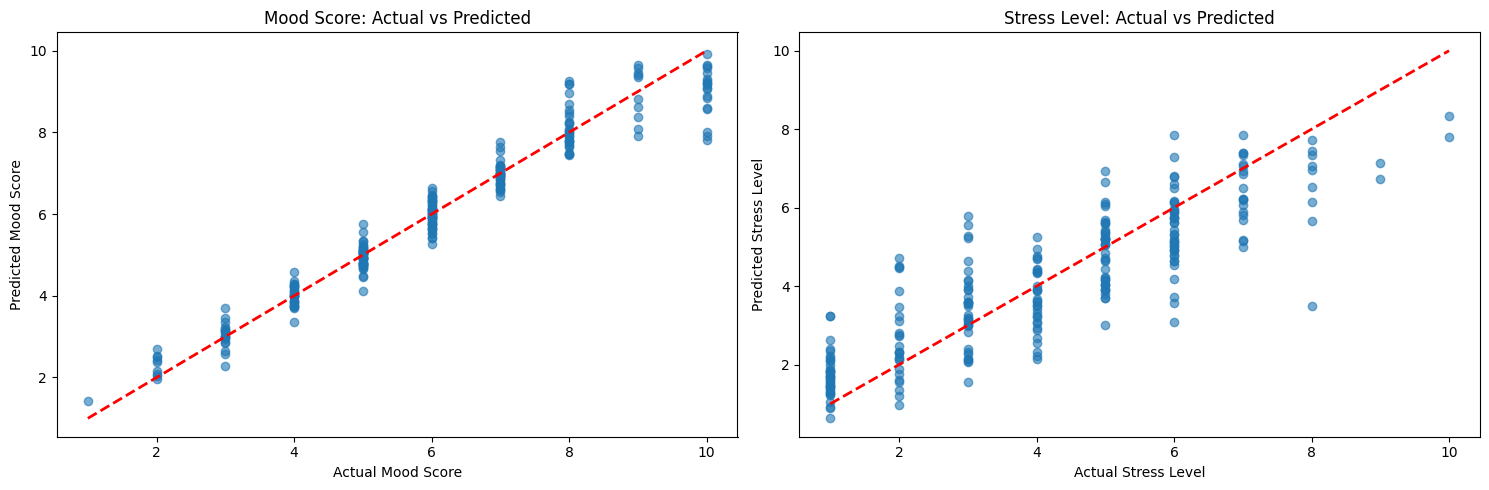

In [21]:
best_model = multi_models['GradientBoosting']
y_pred_best = best_model.predict(X_val_multi_scaled)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# plot for mood score
axes[0].scatter(y_val_multi['Mood_Score'], y_pred_best[:, 0], alpha=0.6)
axes[0].plot([y_val_multi['Mood_Score'].min(), y_val_multi['Mood_Score'].max()],
             [y_val_multi['Mood_Score'].min(), y_val_multi['Mood_Score'].max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Mood Score')
axes[0].set_ylabel('Predicted Mood Score')
axes[0].set_title('Mood Score: Actual vs Predicted')

# Plot for stress level
axes[1].scatter(y_val_multi['Stress_Level'], y_pred_best[:, 1], alpha=0.6)
axes[1].plot([y_val_multi['Stress_Level'].min(), y_val_multi['Stress_Level'].max()],
             [y_val_multi['Stress_Level'].min(), y_val_multi['Stress_Level'].max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Stress Level')
axes[1].set_ylabel('Predicted Stress Level')
axes[1].set_title('Stress Level: Actual vs Predicted')

plt.tight_layout()
plt.show()

In [22]:
best_model = multi_models['GradientBoosting']
test_predictions = best_model.predict(X_test_multi_scaled)


test_results = pd.DataFrame({
    'Predicted_Mood_Score': test_predictions[:, 0],
    'Predicted_Stress_Level': test_predictions[:, 1]
})

print('Test Set Predictions:')
print(test_results.head(10))

Test Set Predictions:
   Predicted_Mood_Score  Predicted_Stress_Level
0              5.284077                4.253312
1              4.464935                5.812367
2              7.957535                2.116628
3              8.328856                2.581169
4              6.121206                4.034751
5              2.606949                6.803057
6              4.520618                5.984267
7              6.573581                3.581790
8              5.855413                4.383935
9              6.013630                4.330459


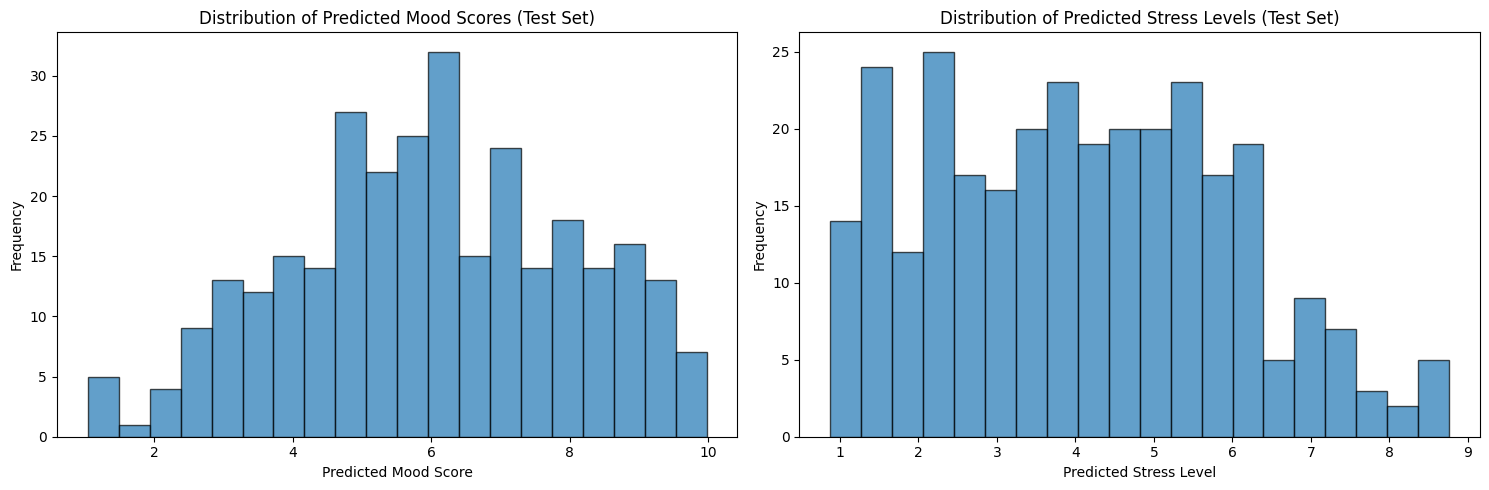

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(test_predictions[:, 0], bins=20, alpha=.7, edgecolor='black')
axes[0].set_xlabel('Predicted Mood Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Predicted Mood Scores (Test Set)')

axes[1].hist(test_predictions[:, 1], bins=20, alpha=.7, edgecolor='black')
axes[1].set_xlabel('Predicted Stress Level')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Predicted Stress Levels (Test Set)')

plt.tight_layout()
plt.show()

## HyperParameter Tuning with Optuna

In [24]:
def objective(trial):
    """
    Objective function for Optuna hyperparameter tuning.
    """
    
    # Hyperparameter suggestions for GradientBoostingRegressor
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state': 42
    }
    
    # Create model with suggested parameters
    model = MultiOutputRegressor(GradientBoostingRegressor(**params))
    
    # Training
    model.fit(X_train_multi_scaled, y_train_multi)
    
    # Prediction
    y_pred = model.predict(X_val_multi_scaled)
    
    # Calculate combined score (weighted average of both targets)
    # Mood Score is more important because the performance is good, focus to improve Stress Level
    mood_r2 = r2_score(y_val_multi.iloc[:, 0], y_pred[:, 0])
    stress_r2 = r2_score(y_val_multi.iloc[:, 1], y_pred[:, 1])
    
    # Weighted score: 40% mood, 60% stress
    combined_score = 0.4 * mood_r2 + 0.6 * stress_r2
    
    return combined_score

In [25]:
# create study
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    study_name='mental_health_optimization'
)

print("🔍 Starting Optuna Hyperparameter Optimization...")
print("Target: Maximize combined R² score (40% Mood + 60% Stress)")
print("=" * 60)

# Optimize
study.optimize(objective, n_trials=100, show_progress_bar=True)


print("\n🎯 Optimization Results:")
print("=" * 40)
print(f"Best combined R² score: {study.best_value:.4f}")
print(f"Best parameters: {study.best_params}")


[I 2025-08-06 14:13:51,008] A new study created in memory with name: mental_health_optimization


🔍 Starting Optuna Hyperparameter Optimization...
Target: Maximize combined R² score (40% Mood + 60% Stress)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-06 14:13:52,281] Trial 0 finished with value: 0.7934140407502717 and parameters: {'n_estimators': 412, 'learning_rate': 0.09556428757689246, 'max_depth': 8, 'subsample': 0.8394633936788146, 'max_features': 'sqrt', 'min_samples_split': 18, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7934140407502717.
[I 2025-08-06 14:13:54,064] Trial 1 finished with value: 0.8135245085594205 and parameters: {'n_estimators': 513, 'learning_rate': 0.011852604486622221, 'max_depth': 10, 'subsample': 0.9329770563201687, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8135245085594205.
[I 2025-08-06 14:13:56,161] Trial 2 finished with value: 0.8130522853749365 and parameters: {'n_estimators': 430, 'learning_rate': 0.036210622617823776, 'max_depth': 7, 'subsample': 0.6557975442608167, 'max_features': None, 'min_samples_split': 16, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8135245085594205.
[I 2025-08-06 14:13:57,584] Trial 

In [26]:
# Train model dengan best parameters
print("\n🚀 Training Optimized Model...")
best_params = study.best_params
optimized_model = MultiOutputRegressor(GradientBoostingRegressor(**best_params))

# Training
optimized_model.fit(X_train_multi_scaled, y_train_multi)

y_pred_optimized = optimized_model.predict(X_val_multi_scaled)

print("\n📊 Optimized Model Performance:")
print("=" * 50)

targets = ['Mood_Score', 'Stress_Level']
for i, target in enumerate(targets):
    y_true = y_val_multi.iloc[:, i]
    y_pred = y_pred_optimized[:, i]
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f'\n{target}:')
    print(f' MAE: {mae:.4f}')
    print(f' RMSE: {rmse:.4f}')
    print(f'R2 Score: {r2:.4f}')


🚀 Training Optimized Model...

📊 Optimized Model Performance:

Mood_Score:
 MAE: 0.3427
 RMSE: 0.4812
R2 Score: 0.9460

Stress_Level:
 MAE: 0.8288
 RMSE: 1.0609
R2 Score: 0.7534


In [27]:
prev_mood_r2 = 0.9506
prev_stress_r2 = 0.7463


curr_mood_r2 = r2_score(y_val_multi.iloc[:, 0], y_pred_optimized[:, 0])
curr_stress_r2 = r2_score(y_val_multi.iloc[:, 1], y_pred_optimized[:, 1])

print('Mood Score R2:')
print(f'Previous: {prev_mood_r2:.4f}')
print(f'Optimized: {curr_mood_r2:.4f}')
print(f'Improvement: {curr_mood_r2 - prev_mood_r2:+.4f}')

print('Stress Level R2:')
print(f'Previous: {prev_stress_r2:.4f}')
print(f'Optimized: {curr_stress_r2:.4f}')
print(f'Improvement: {curr_stress_r2 - prev_stress_r2:+.4f}')


Mood Score R2:
Previous: 0.9506
Optimized: 0.9460
Improvement: -0.0046
Stress Level R2:
Previous: 0.7463
Optimized: 0.7534
Improvement: +0.0071


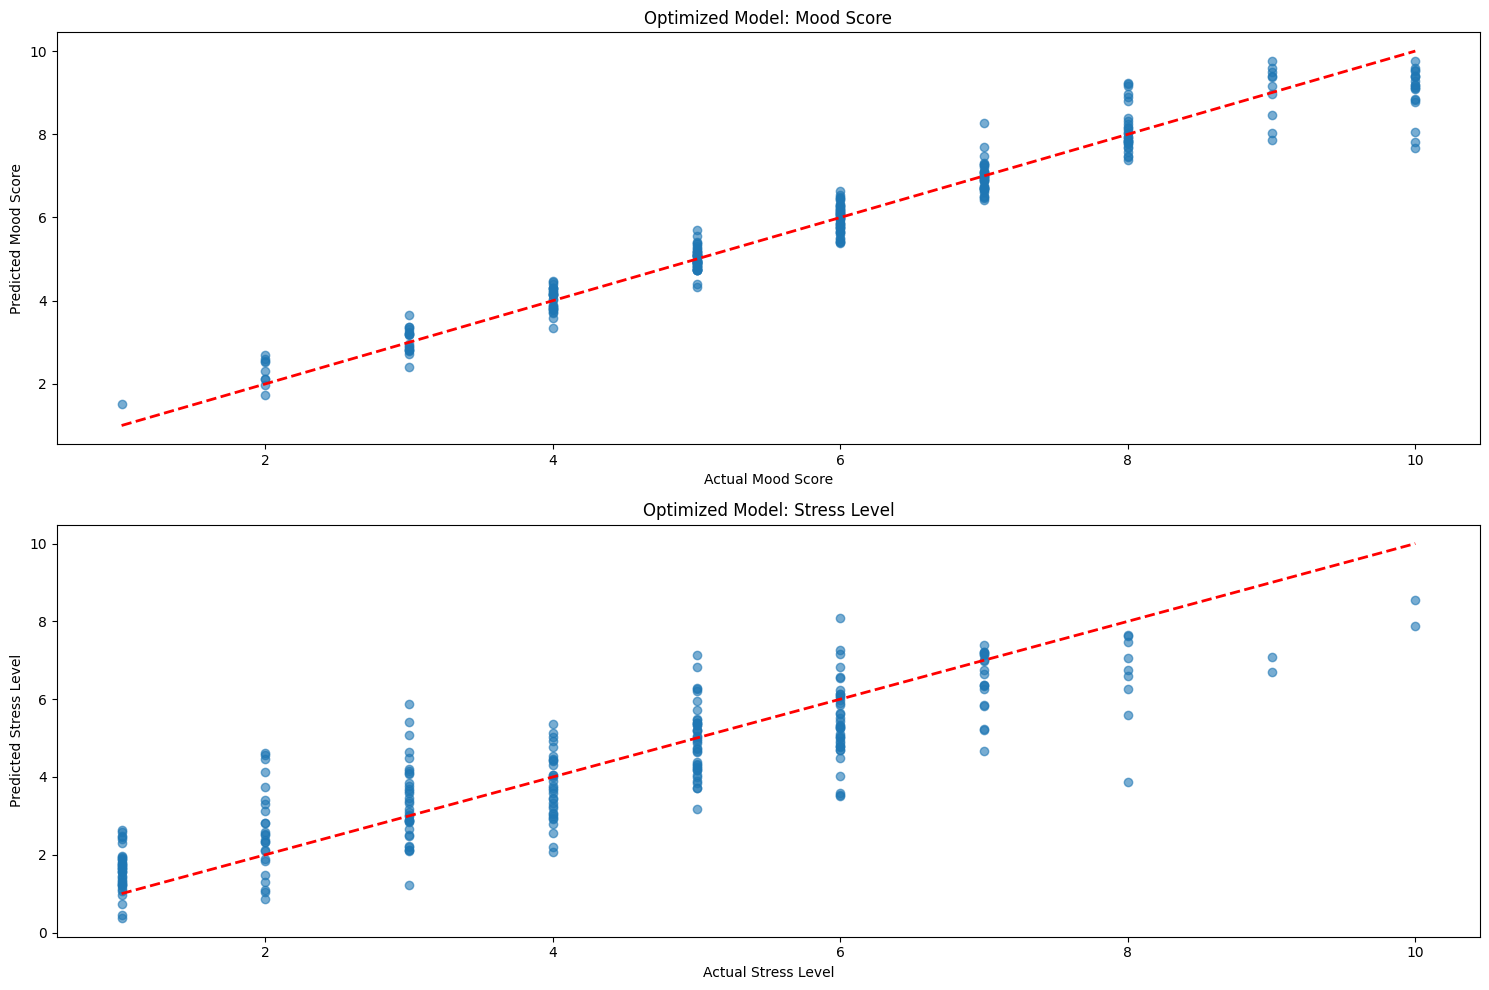

In [28]:
# Visualisasi sederhana tanpa optuna.visualization
fig, axes = plt.subplots(2, 1, figsize=(15, 10))


# 3. Actual vs Predicted - Mood Score
axes[0].scatter(y_val_multi['Mood_Score'], y_pred_optimized[:, 0], alpha=0.6)
axes[0].plot([y_val_multi['Mood_Score'].min(), y_val_multi['Mood_Score'].max()],
                [y_val_multi['Mood_Score'].min(), y_val_multi['Mood_Score'].max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Mood Score')
axes[0].set_ylabel('Predicted Mood Score')
axes[0].set_title('Optimized Model: Mood Score')

# 4. Actual vs Predicted - Stress Level
axes[1].scatter(y_val_multi['Stress_Level'], y_pred_optimized[:, 1], alpha=0.6)
axes[1].plot([y_val_multi['Stress_Level'].min(), y_val_multi['Stress_Level'].max()],
                [y_val_multi['Stress_Level'].min(), y_val_multi['Stress_Level'].max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Stress Level')
axes[1].set_ylabel('Predicted Stress Level')
axes[1].set_title('Optimized Model: Stress Level')

plt.tight_layout()
plt.show()

<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

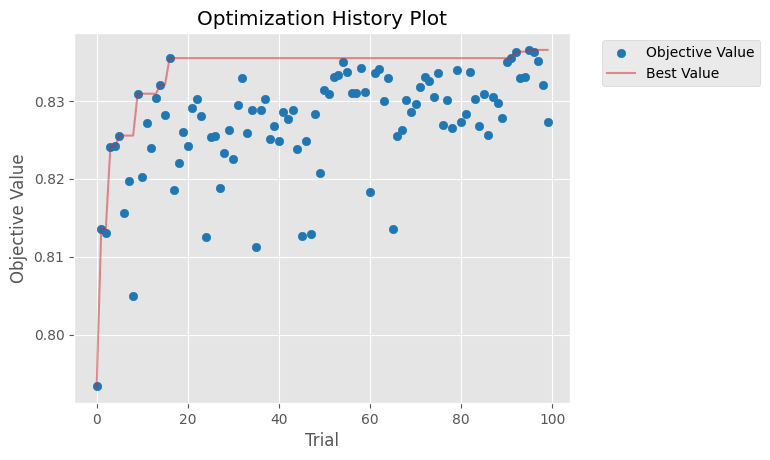

In [29]:
optuna.visualization.matplotlib.plot_optimization_history(study)

<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

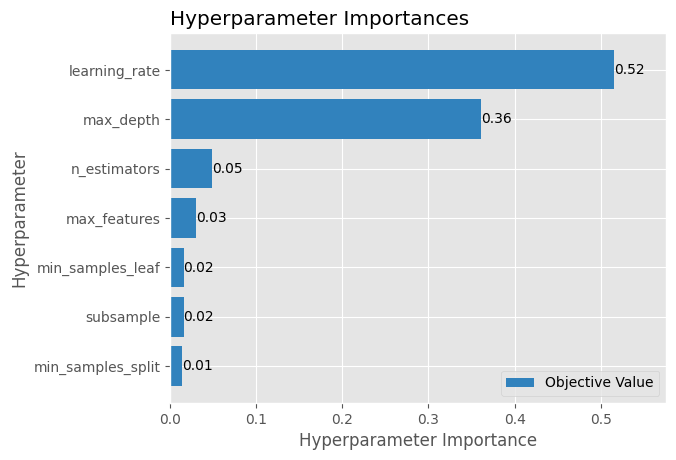

In [30]:
optuna.visualization.matplotlib.plot_param_importances(study)

In [31]:
import joblib

joblib.dump(le_diet_quality, '../models/le_diet_quality.joblib')
joblib.dump(le_sleep_quality, '../models/le_sleep_quality.joblib')
joblib.dump(le_weather, '../models/le_weather.joblib')
joblib.dump(scaler, '../models/scaler.joblib')

joblib.dump(optimized_model, '../models/gradient_boosting_tuning.joblib')

['../models/gradient_boosting_tuning.joblib']